In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
#load the data 
dtype_spec_test = {
    'column_6_name': 'str',  # Replace 'column_6_name' with the actual name of column 6 in merged_test.csv
}

dtype_spec_train = {
    'column_7_name': 'str',  # Replace 'column_7_name' with the actual name of column 7 in merged_train.csv
}
train_eng = pd.read_csv('train_eng.csv', dtype=dtype_spec_test, low_memory=False)
test_eng = pd.read_csv('test_eng.csv', dtype=dtype_spec_test, low_memory=False)

In [3]:
train_eng.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,competitiondistance,...,"promointerval_Jan,Apr,Jul,Oct","promointerval_Mar,Jun,Sept,Dec",promo2_start_date,promo2_start_month,promo2_start_year,promo2_start_day,promo2_start_day_of_week,quarter,week_of_year,is_weekend
0,1,5,2015-07-31,5263,555,1,1,0,1,1270.0,...,False,False,NaN,NaN,NaN,NaN,NaN,3,31,False
1,2,5,2015-07-31,6064,625,1,1,0,1,570.0,...,True,False,2010-03-29,3.0,2010.0,29.0,0.0,3,31,False
2,3,5,2015-07-31,8314,821,1,1,0,1,14130.0,...,True,False,2011-04-04,4.0,2011.0,4.0,0.0,3,31,False
3,4,5,2015-07-31,13995,1498,1,1,0,1,620.0,...,False,False,NaN,NaN,NaN,NaN,NaN,3,31,False
4,5,5,2015-07-31,4822,559,1,1,0,1,29910.0,...,False,False,NaN,NaN,NaN,NaN,NaN,3,31,False


In [4]:
test_eng.head()
#number of rows on test set
test_eng.shape

(41088, 41)

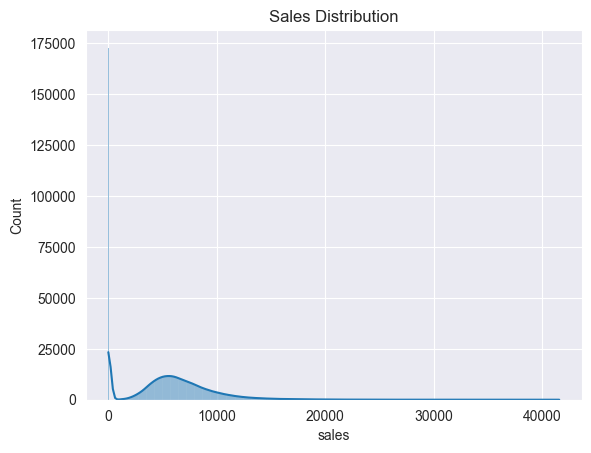

Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Sample RMSPE components: 53778     0.001169
623876    0.042051
316322    0.001847
353987    0.000358
913745    0.020085
906615    0.017609
910488    0.032101
336070    0.003406
184941    1.250506
776743    0.000000
Name: sales, dtype: float64
Validation RMSPE: 792105757828.0662
Sample submission saved to /Users/luanagiusto/PycharmProjects/forecasting_retail/sample_submission_rf.csv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the dependent variable and the list of categorical variables
dep_var = 'sales'
cat_names = train_eng.select_dtypes(include=['object', 'category']).columns.tolist()

# Ensure the target column 'sales' is in the train set
if dep_var not in train_eng.columns:
    raise KeyError(f"Column {dep_var} must be present in the training set")

# Separate features (X) and target variable (y) for the train set
X_train = train_eng.drop(columns=[dep_var, 'customers'])
y_train = train_eng[dep_var]

# For the test set, ensure 'sales' and 'customers' are removed
X_test = test_eng.drop(columns=['sales', 'customers'], errors='ignore')

# Encode categorical variables
X_train = pd.get_dummies(X_train, columns=cat_names, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_names, drop_first=True)

# Align test set columns with train set columns to avoid mismatch
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

### 1. Check the Data Distribution ###
# Plot sales distribution
sns.histplot(train_eng['sales'], kde=True)
plt.title('Sales Distribution')
plt.show()

### 2. Sample 20% of the Data ###
# Take a random sample of 20% of the training data to handle memory issues
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Optionally, scale the continuous features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_sample)  # Fit on the 20% sampled data
X_test_scaled = scaler.transform(X_test)  # Apply the same transformation to the test data

# Split data for validation (use 20% sampled data)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train_sample, test_size=0.2, random_state=42)

### 3. Initialize the Random Forest Model ###
rf_model = RandomForestRegressor(random_state=42)

### 4. Perform Hyperparameter Tuning with GridSearchCV ###
# Set up a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
}

# Initialize the GridSearch with RandomForestRegressor
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_split, y_train_split)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters
rf_best_model = RandomForestRegressor(**best_params, random_state=42)
rf_best_model.fit(X_train_split, y_train_split)

### 5. Define RMSPE function with epsilon to avoid division by zero ###
def rmspe(y_true, y_pred, epsilon=1e-10):
    diff = np.square((y_true - y_pred) / (y_true + epsilon))
    print("Sample RMSPE components:", diff[:10])  # Print first 10 for debugging
    return np.sqrt(np.mean(diff))

### 6. Evaluate the Model on Validation Set ###
y_val_pred = rf_best_model.predict(X_val_split)
val_rmspe = rmspe(y_val_split, y_val_pred)
print(f'Validation RMSPE: {val_rmspe}')

### 7. Predict on the Test Set ###
y_test_pred = rf_best_model.predict(X_test_scaled)

# Ensure the predictions are non-negative (since sales cannot be negative)
y_test_pred = np.maximum(0, y_test_pred)

### 8. Create Submission File ###
# Assume that 'Id' is present in the test dataset and should be included in the submission
test_ids = test_eng['id']  # Ensure 'id' exists in the test dataset

# Create a submission dataframe with 'Id' from the test set and 'Sales' from the predictions
sample_submission_rf = pd.DataFrame({
    'Id': test_ids,
    'Sales': y_test_pred
})

# Save the submission file
submission_path = '/Users/luanagiusto/PycharmProjects/forecasting_retail/sample_submission_rf.csv'
sample_submission_rf.to_csv(submission_path, index=False)

print(f'Sample submission saved to {submission_path}')


In [6]:
#number of rows on sample submission
sample_submission_rf.shape


(41088, 2)